In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 11
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((516, 12, 1), (516,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT11/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 39s 509ms/step - loss: 0.3273 - root_mean_squared_error: 0.5721 - val_loss: 0.1681 - val_root_mean_squared_error: 0.4100
Epoch 2/50
53/53 [==============================] - 25s 477ms/step - loss: 0.0916 - root_mean_squared_error: 0.3027 - val_loss: 0.0867 - val_root_mean_squared_error: 0.2944
Epoch 3/50
53/53 [==============================] - 24s 464ms/step - loss: 0.0646 - root_mean_squared_error: 0.2542 - val_loss: 0.0737 - val_root_mean_squared_error: 0.2714
Epoch 4/50
53/53 [==============================] - 25s 487ms/step - loss: 0.0521 - root_mean_squared_error: 0.2282 - val_loss: 0.0568 - val_root_mean_squared_error: 0.2383
Epoch 5/50
53/53 [==============================] - 25s 487ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1971
Epoch 6/50
53/53 [==============================] - 26s 506ms/step - loss: 0.0258 - root_mean_squared_error: 0.1605 - val_loss: 0.0259 

Epoch 35/50
53/53 [==============================] - 3s 64ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 36/50
53/53 [==============================] - 26s 507ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 37/50
53/53 [==============================] - 4s 68ms/step - loss: 0.0064 - root_mean_squared_error: 0.0797 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 38/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 39/50
53/53 [==============================] - 26s 505ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827
Epoch 40/50
53/53 [==============================] - 26s 501ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0059 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

10.595059422651927 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

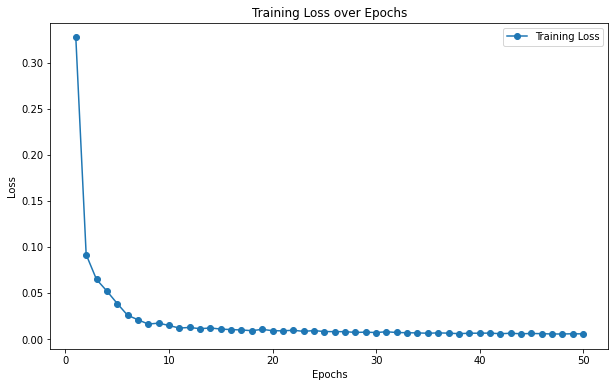

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

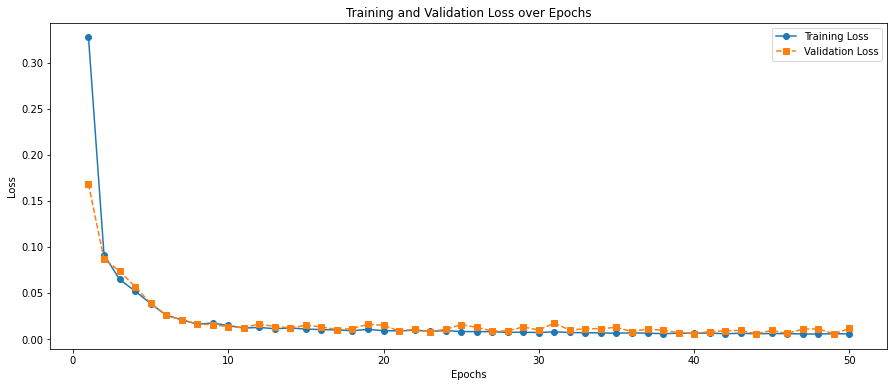

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT11/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 27ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09195694099581651
MAE : 0.07718791439842192


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,7.569952e+05,979418.298
1,1.861907e+06,2086269.569
2,2.648312e+06,2852731.016
3,3.092918e+06,3452823.613
4,3.425494e+06,3846843.974
5,3.644492e+06,4005222.451
6,3.755456e+06,4129684.505
7,3.702449e+06,4130311.577
8,3.460647e+06,3987590.376
9,2.668266e+06,2531664.630


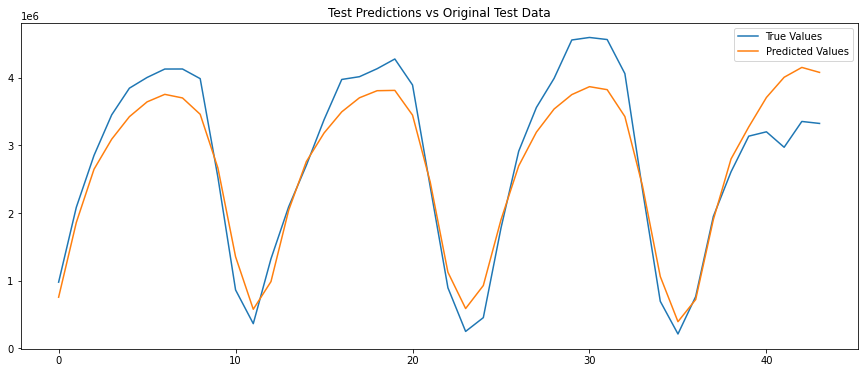

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 37ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

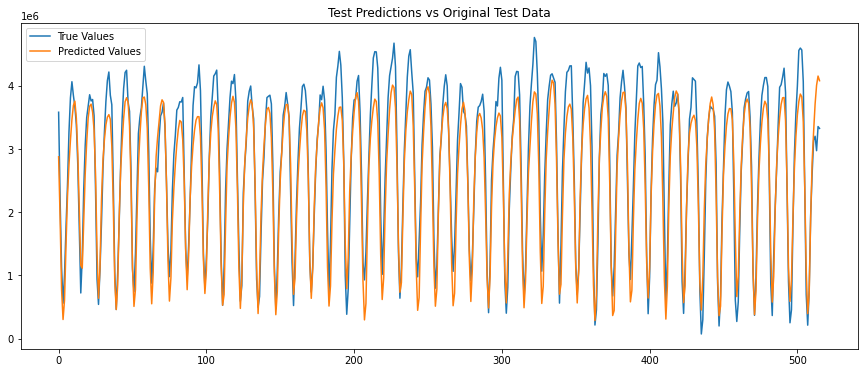

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()